In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Outline
1. Import Data
2. Missing Values
3. EDA
4. Pre-processing
5. Model Building

## 1. Import Data

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head(10)

,Id,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,...,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6,y2
0,706,762.212216,753.162754,754.610620,762.787135,768.170347,769.815486,750.950000,0.902534,0.873314,...,87.200000,87.2,1.788239,1.883677,1.894829,1.865024,1.755078,2.030000,2.03,0.72
1,239,762.671780,746.631882,745.807832,755.992886,761.814347,766.110745,762.535189,1.366119,1.358298,...,72.613391,87.2,1.920067,1.820872,1.863998,1.827162,1.964556,1.965790,2.03,0.62
2,613,766.867777,756.642963,750.059697,756.377980,760.087594,758.380275,750.950000,0.821431,0.825063,...,87.200000,87.2,2.084817,2.019537,2.197232,2.032493,1.976534,2.030000,2.03,0.57
3,588,751.077287,758.230866,761.391167,763.190054,768.715192,770.447814,750.950000,0.712874,0.744777,...,87.200000,87.2,1.853655,1.848088,1.880007,2.068814,1.871028,2.030000,2.03,1.01
4,780,772.430815,772.254344,772.322597,771.926261,768.820073,772.908223,750.950000,0.742664,0.676266,...,87.200000,87.2,2.211915,2.387687,2.368041,2.360032,2.352961,2.030000,2.03,-0.42
5,511,759.214578,753.733085,749.039611,748.722547,755.826560,755.238797,750.950000,1.478023,1.418315,...,87.200000,87.2,2.167988,2.196053,2.093723,2.251953,2.272081,2.030000,2.03,0.43
6,482,760.229220,763.722385,761.339597,764.196596,760.680692,764.814620,753.287722,1.375937,1.353992,...,88.504767,87.2,1.884157,2.094220,1.693284,1.979710,2.124493,1.851155,2.03,0.60
7,240,758.180000,752.600192,754.085223,743.205153,746.526853,754.717348,750.950000,1.267441,1.372429,...,87.200000,87.2,1.748998,1.695568,1.874299,1.888195,1.746471,2.030000,2.03,0.62
8,483,753.303128,755.876089,760.244568,760.718240,758.830167,763.838986,750.950000,1.401395,1.346915,...,87.200000,87.2,2.125798,2.081001,2.165167,1.972106,1.815908,2.030000,2.03,0.60
9,230,753.608577,752.897145,735.876381,743.151943,753.097965,756.884810,750.950000,0.544512,0.629572,...,87.200000,87.2,2.033285,1.949407,2.071290,2.136080,1.957290,2.030000,2.03,0.46


### Meta-Data

1. Id : Unique identifier of Each Batch
2. y2 : Target variable representing Batch Performance
3. xo_to-x54_t6 : Data of 55 sensor for 6 Time Interval

## 2. Missing Values

Total number of duplicate columns :  34


(array([  0.5,   5.5,  10.5,  15.5,  20.5,  25.5,  30.5,  35.5,  40.5,
         45.5,  50.5,  55.5,  60.5,  65.5,  70.5,  75.5,  80.5,  85.5,
         90.5,  95.5, 100.5, 105.5, 110.5, 115.5, 120.5, 125.5, 130.5,
        135.5, 140.5, 145.5, 150.5, 155.5, 160.5, 165.5, 170.5, 175.5,
        180.5, 185.5, 190.5, 195.5, 200.5, 205.5, 210.5, 215.5, 220.5,
        225.5, 230.5, 235.5, 240.5, 245.5, 250.5, 255.5, 260.5, 265.5,
        270.5, 275.5, 280.5, 285.5, 290.5, 295.5, 300.5, 305.5, 310.5,
        315.5, 320.5, 325.5, 330.5, 335.5, 340.5, 345.5, 350.5, 355.5,
        360.5, 365.5, 370.5, 375.5, 380.5, 385.5]),
 <a list of 78 Text xticklabel objects>)

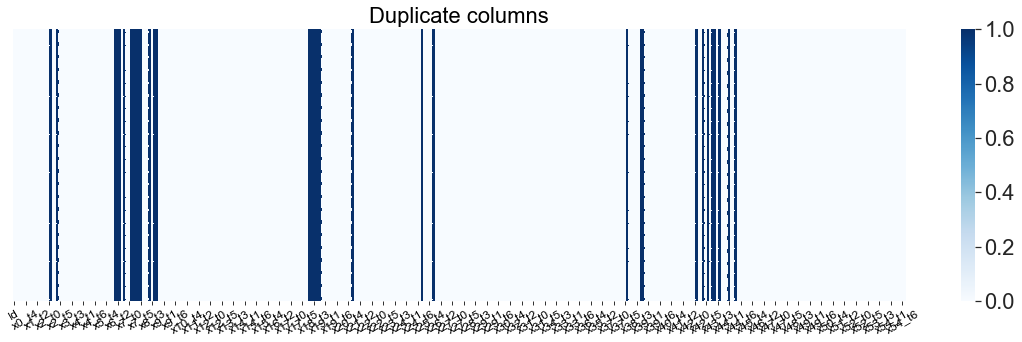

In [3]:
# Find Duplicate columns

train3 = train.copy()
a = train3.columns.tolist()

# Drop duplicate columns
train2 = train3.T.drop_duplicates(keep='first').T
b=train2.columns

print('Total number of duplicate columns : ', (len(a)-len(b)))

# save duplicate columns name
dupp = []
for i in range(len(a)):
    if a[i] not in b:
        dupp.append(a[i])
        
for i in range(len(dupp)):
    train3[dupp[i]] = np.nan

# plot missing values
fig, ax = plt.subplots(figsize=(20,5))
sns.set(font_scale=2)
plt.title('Duplicate columns', fontsize=22)
sns.heatmap(train3.isnull(), cmap="Blues", yticklabels=False, ax=ax)
plt.xticks(fontsize = 12, rotation = 30)

## 3. EDA

In [4]:
# 0 variance columns
train4 = train.copy()
num_zero_var = 0
for i in range(387):
    a = train4[train4.columns[i]].var()
    if a == 0:
        num_zero_var += 1
    
print('Total {} coumns have 0 variance'.format(num_zero_var))

Total 15 coumns have 0 variance


Text(0.5, 1.0, 'Top 15 correlated features with target')

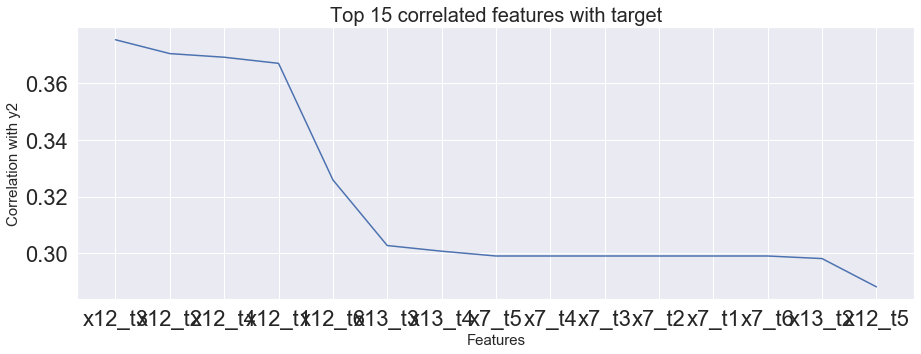

In [5]:
# most correlated features
corr_df = pd.DataFrame({'cols':train.columns[1:-1]})
corr_df['val'] = 0

for i in range(len(train.columns[1:-1])):
    corr_df.iloc[i,1] = (train['y2'].corr(train[train.columns[i]]))
    
corr_df.val = corr_df.val.apply(lambda x : np.abs(x))
corr_df = corr_df.sort_values(by = ['val'],ascending=False).dropna()

plt.figure(figsize = (15,5))
plt.plot(corr_df.cols[:15],corr_df.val[:15])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Correlation with y2', fontsize = 15)
plt.title('Top 15 correlated features with target', fontsize = 20)

In [6]:
# Find columns average
cols = []
for i in range(1,train.shape[1]-5,7):
    train[train.columns[i]] = (train[train.columns[i]]+train[train.columns[i+1]]+train[train.columns[i+2]]+train[train.columns[i+3]]+train[train.columns[i+4]]+train[train.columns[i+5]]+train[train.columns[i+6]])/7
    cols.append(train.columns[i])

cols.append('Id')
cols.append('y2')


In [7]:
# Drop rest of the columns
train.drop([c for c in train.columns if c not in cols], axis = 1, inplace = True)
train4 = train.copy()

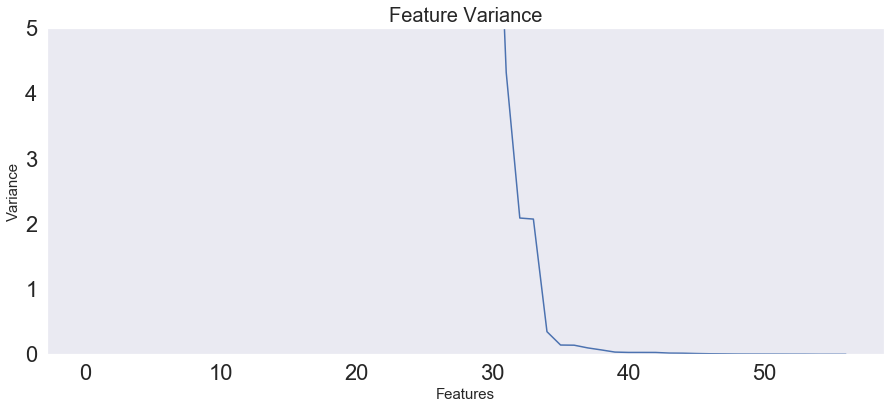

In [8]:
# plot variance
plt.figure(figsize=(15,6))
plt.plot(range(57),train.var().sort_values(ascending=False))
plt.ylim(0,5)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Variance', fontsize = 15)
plt.title('Feature Variance', fontsize = 20)
plt.grid()

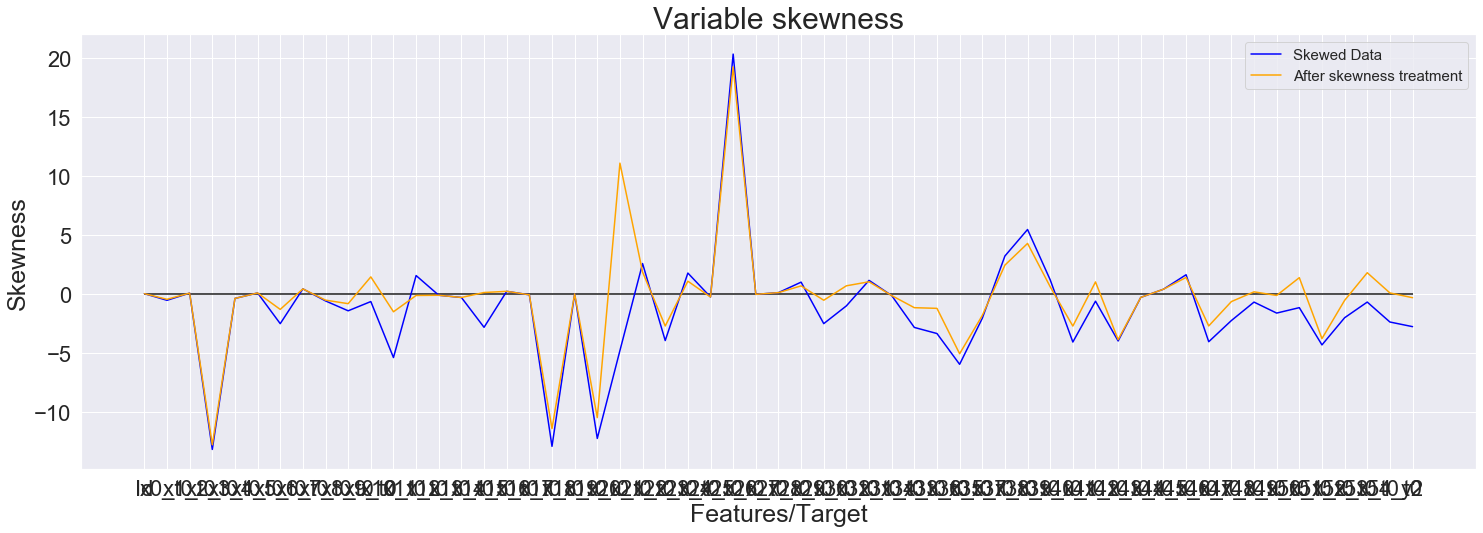

In [9]:
# skewness treat
plt.figure(figsize = (25,8))
plt.plot(train4.skew(), color = 'blue', label = 'Skewed Data')

memo = []
for i in range(len(train4.skew())):
    if train4.skew()[i] > 0.5:
        train4[train4.skew().index[i]] = train4[train4.skew().index[i]].apply(lambda x : np.log1p(x))
        memo.append(1)
    elif train4.skew()[i] < -0.5:
        train4[train4.skew().index[i]] = train4[train4.skew().index[i]].apply(lambda x :x*x*x)
        memo.append(-1)
    else:
        memo.append(0)
        
plt.plot(train4.skew(), color = 'orange', label = 'After skewness treatment')
plt.hlines(0,0,56)
plt.legend(prop={'size': 15})
plt.xlabel('Features/Target', fontsize = 25)
plt.ylabel('Skewness', fontsize = 25)
plt.title('Variable skewness', fontsize = 30)
plt.show()

## 4. Pre-processing

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

In [11]:
# split predictors and target
X = train.drop('y2',axis = 1)
y = train['y2'].copy()

# Standardize independent variables
ss = StandardScaler()
X = ss.fit_transform(X)

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

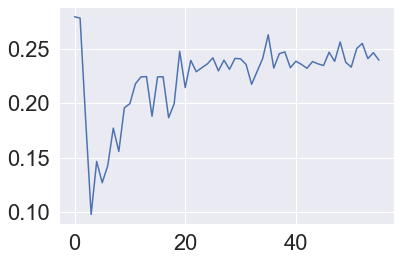

In [12]:
# rfecv
from sklearn.ensemble import RandomForestRegressor

rfe_estimator = RandomForestRegressor()
rfecv_1 = RFECV(rfe_estimator, step=1, min_features_to_select=1, scoring='r2', verbose=12, n_jobs=-1)
rfecv_1.fit(X,y)
X_rfe = rfecv_1.transform(X)
plt.plot(rfecv_1.grid_scores_[:])

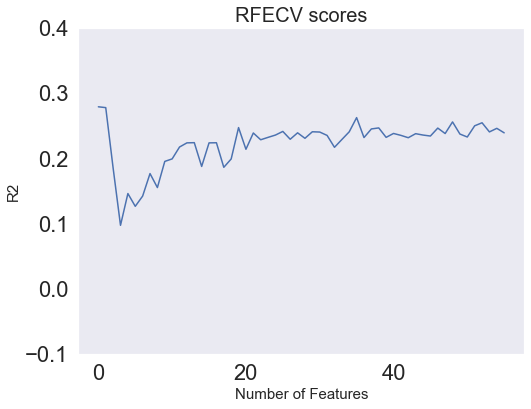

In [13]:
# plot r2 score vs number of features selected by rfecv
plt.figure(figsize=(8,6))
plt.plot(rfecv_1.grid_scores_[:])
plt.xlabel('Number of Features', fontsize = 15)
plt.ylabel('R2', fontsize = 15)
plt.title('RFECV scores', fontsize = 20)
plt.ylim(-0.1,0.4)
plt.grid()
plt.show()

## 5.Model Building

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [15]:
# Cross-Validation
lr = LinearRegression()
l1 = Lasso()
l2 = Ridge()
svr = SVR(kernel='linear')
rf = RandomForestRegressor(n_jobs = -1)
xgb = XGBRegressor()

print('Çross-validation Scores for Different Models')
lr_cv = cross_val_score(lr, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Linear Regression : ', round(lr_cv,3))
l1_cv = cross_val_score(l1, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Ridge : ', round(l1_cv,3))
l2_cv = cross_val_score(l2, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Lasso : ', round(l2_cv,3))
svr_cv = cross_val_score(svr, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('SVR : ', round(svr_cv,3))
rf_cv = cross_val_score(rf, X_rfe,y, scoring = 'r2', cv = 8, n_jobs = -1).mean()
print('RandomForest : ', round(rf_cv,3))
xgb_cv = cross_val_score(xgb, X_rfe,y, scoring = 'r2', cv = 8, n_jobs = -1).mean()
print('XGBoost : ', round(xgb_cv,3))

Çross-validation Scores for Different Models
Linear Regression :  -0.004
Ridge :  -0.002
Lasso :  -0.004
SVR :  -0.006
RandomForest :  0.249
XGBoost :  0.116


In [16]:
# Model Stacking 
from sklearn.ensemble import StackingRegressor

estimators = [
     ('lr', LinearRegression()),('l1', Lasso()),('l2', Ridge()),
     ('svr', SVR(kernel='linear')),('rf', RandomForestRegressor(n_jobs = -1)),('xgb', XGBRegressor())
]
sreg = StackingRegressor(estimators=estimators,
                         final_estimator=Ridge())
stk_cv = cross_val_score(sreg, X_rfe,y, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Cross-validation Result for Stacking Regressor : ',round(stk_cv,3))

Cross-validation Result for Stacking Regressor :  0.332


In [17]:
# Over-sampling
import smogn

train_smogn = smogn.smoter(data = train,y = "y2")

r_index: 100%|########################################################################| 82/82 [00:00<00:00, 199.01it/s]


In [18]:
print('Shape of training data after over-sampling ',train_smogn.shape, ' whereas original train data shape = ', train.shape)

Shape of training data after over-sampling  (856, 57)  whereas original train data shape =  (794, 57)


In [19]:
# split over sampled data
Xs = train_smogn.drop('y2',axis = 1)
ys = train_smogn['y2'].copy()

# Standardize
sss = StandardScaler()
Xs = sss.fit_transform(Xs)

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.


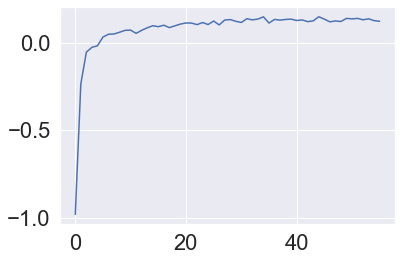

In [20]:
# RFECV for over-sampled data
rfe_estimators = RandomForestRegressor()
rfecv_1s = RFECV(rfe_estimators, step=1, min_features_to_select=1, scoring='r2', verbose=12, n_jobs=-1)
rfecv_1s.fit(Xs,ys)
X_rfes = rfecv_1s.transform(Xs)
plt.plot(rfecv_1s.grid_scores_[:])

In [49]:
# Cross validating Vanilla models

print('Çross-validation Scores for Different Models')
lrs_cv = cross_val_score(LinearRegression(), X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Linear Regression : ',round(lrs_cv,3))
l1s_cv = cross_val_score(Lasso(), X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Lasso : ',round(l1s_cv,3))
l2s_cv = cross_val_score(Ridge(), X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Ridge : ',round(l2s_cv,3))
svrs_cv = cross_val_score(SVR(kernel='linear'), X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('SVR : ',round(svrs_cv,3))
rfs_cv = cross_val_score(RandomForestRegressor(n_jobs = -1), X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('RandomForest : ',round(rfs_cv,3))
xgbs_cv = cross_val_score(XGBRegressor(), X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('XGBoost : ',round(xgbs_cv,3))

Çross-validation Scores for Different Models
Linear Regression :  -0.237
Lasso :  -1.2
Ridge :  -0.237
SVR :  -0.261
RandomForest :  0.121
XGBoost :  0.059


In [52]:
# xgb hyper-parameter tuning

# Parameter Grid
grid = {
    'max_depth' : [4],'min_child_weight' : [1],
    'n_estimators' : [2000],
    'gamma' : [0],
    'subsample':[1],'colsample_bytree':[0.55],
    'reg_alpha':[0.001],
    'learning_rate' : [0.3]
}
gs1 = GridSearchCV(XGBRegressor(), grid, n_jobs=-1, verbose=2, scoring='r2', return_train_score=True)
gs1.fit(X_rfes,ys)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.1s finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
     

In [53]:
# print best tuning scores & parameters
print('After Hyper-parameter Tuning')
print('Best params : ',gs1.best_params_)
print('Best Score : ',gs1.best_score_)

After Hyper-parameter Tuning
Best params :  {'colsample_bytree': 0.55, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 2000, 'reg_alpha': 0.001, 'subsample': 1}
Best Score :  0.2048909677123219


In [54]:
# best model
xgb_ht = XGBRegressor(max_depth = 6, colsample_bytree = 0.85, gamma = 0, learning_rate = 0.15,
                      min_child_weight = 1, n_estimators = 1000, reg_alpha = 0.1, subsample = 0.95)
print('Hyper-parameter tuned XGBRegressor : ')
xgb_ht.fit(X_rfes,ys)

Hyper-parameter tuned XGBRegressor : 


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
# stacking regressor - stacking Linear Regression, RandomForest & XGBoost

estimators = [
     ('lr', LinearRegression()),
    ('l1', Lasso()),
    ('l2', Ridge()),
     ('svr', SVR(kernel='linear')),
    ('rf', RandomForestRegressor(n_jobs = -1)),
    ('xgb', xgb_ht)
]

sreg = StackingRegressor(estimators = estimators, final_estimator = Ridge())
stk_cv = cross_val_score(sreg, X_rfes,ys, scoring = 'r2', cv = 5, n_jobs = -1).mean()
print('Mean Cross Validation score for StackingRegressor : ',stk_cv)

Mean Cross Validation score for StackingRegressor :  0.20444772066141859


In [59]:
# test data
# prepare the test data
id_ = test['Id']
cols2 = []
for i in range(1,test.shape[1]-5,7):
    test[test.columns[i]] = (test[test.columns[i]]+test[test.columns[i+1]]+test[test.columns[i+2]]+test[test.columns[i+3]]+
                             test[test.columns[i+4]]+test[test.columns[i+5]]+test[test.columns[i+6]])/7
    cols2.append(test.columns[i])

cols2.append('Id')

test.drop([c for c in test.columns if c not in cols2], axis = 1, inplace = True)
        
test = sss.transform(test)
test = rfecv_1s.transform(test)

In [61]:
# predict and export data
pred_ = xgb_ht.predict(test)
sub = pd.DataFrame({'Id':id_,'y2':pred_})
#sub.to_csv('sub.csv',index = False)

In [62]:
# Further evaluation of model
xtrain,xtest,ytrain,ytest = train_test_split(X_rfes,ys,test_size = 0.2, shuffle = True,random_state = 193)
model_test = XGBRegressor()
pred = sreg.fit(xtrain,ytrain).predict(xtest)

In [65]:
# model performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

# MAE
mae = round(mean_absolute_error(ytest, pred),4)

# RMSE
rmse = round(np.sqrt(mean_squared_error(ytest, pred)),4)

# RMSLE
rmsle = round(np.sqrt(np.mean((np.log1p(pred) - np.log1p(ytest))**2)),4)

# R-Squared
r2 = round(r2_score(ytest, pred),4)

print('       Mean Absolute Error : ',mae)
print('    Root Mean Square Error : ',rmse)
print('Root Mean Square Log Error : ',rmsle)
print('                        r2 : ',r2)

       Mean Absolute Error :  0.1015
    Root Mean Square Error :  0.1367
Root Mean Square Log Error :  0.0958
                        r2 :  0.7444


Text(0.5, 1.0, 'Model performance')

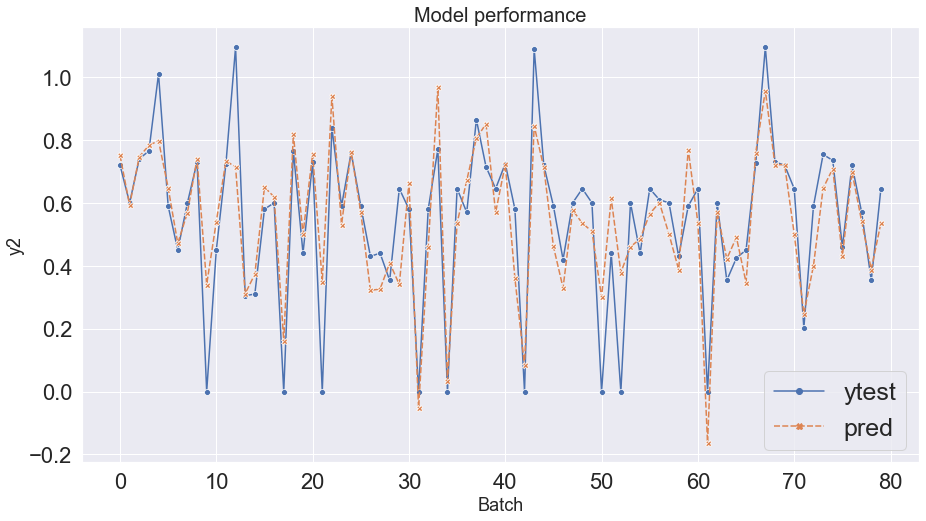

In [66]:
# Model prediction vs Actual performance
plt_df = pd.DataFrame({'ytest':ytest,'pred':pred})

plt.figure(figsize = (15,8))
sns.lineplot(data = plt_df.reset_index().drop('index',axis=1).iloc[:80,:],style="event",markers=True)
plt.xlabel('Batch', fontsize = 18)
plt.ylabel('y2', fontsize = 18)
plt.legend(prop = {'size': 25})
plt.title('Model performance', fontsize=20)

# Analysis
1. The Best Performing Model was XGBoost.
2. Using this model, our client can save a lot of maintainence cost by avoiding extreme Batch's which can lead to machine wear and tear.
3. Due to over-sampling, the model was also able to predict extreme condition/ deviation of a Batch's performance.
4. In Future, I will also try to implement multi level stacking with hyper-parameter tuned models.